In [1]:
import os
import sys

import gurobipy as gp
from gurobipy import GRB

import re

sys.path.append(os.path.abspath("../../util"))
from data_utils import *
from plot_utils import *

In [2]:
file, data = read_data_from_file("../../data/BicyclesRelocationData.xlsx")

In [3]:
# Decision Vars

categories = list(data.columns)

s = {cat: int(data.loc[0, cat]) for cat in categories} # surplus
c = {cat: float(data.loc[1, cat]) for cat in categories} # space

# Capacity
T = 80 

In [4]:
sheets       = [sheet for sheet in file.sheet_names if sheet.startswith("ExpectedProfitsArea")]
destinations = [] 
profit_dict  = {}    

In [5]:
for sheet in sheets:
    area_idx = re.search(r"ExpectedProfitsArea(\d+)", sheet)
    if area_idx:
        area = f"Area{area_idx.group(1)}"
        destinations.append(area)
        profits_data = pd.read_excel(file, sheet_name=sheet, header=0)
        for cat in categories:
            profits = profits_data[cat].dropna().tolist()
            profit_dict[(cat, area)] = profits

In [6]:
def get_profits(i, j, s_i):
    """ fill missing elements with zeros
    Args:
        i ([type]): categories
        j ([type]): destination areas
        s_i ([type]): surplus

    Returns:
        [type]: This function ensures that for every (i,j) the list of profits has exactly s[i] elements. 
    """
    profits = profit_dict.get((i, j), [])
    if len(profits) < s_i:
        profits = profits + [0]*(s_i - len(profits))
        
    return profits

In [7]:
model = gp.Model("bicycles_relocation_opt")
model.setParam("OutputFlag", 0)  # Turns off the log

# Variável binária y[i,j,k] para indicar se a k-ésima bicicleta da categoria i é alocada para a área j.
y = {}

for i in categories:
    for j in destinations:
        for k in range(1, s[i] + 1):
            y[i, j, k] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}_{j}_{k}")

model.update()

# Constraint 1: Sequência dos lucros
for i in categories:
    for j in destinations:
        for k in range(2, s[i] + 1):
            model.addConstr(y[i, j, k] <= y[i, j, k - 1], name=f"seq_{i}_{j}_{k}")

# Constraint 2: Excedente disponível por categoria
for i in categories:
    model.addConstr(
        gp.quicksum(y[i, j, k] for j in destinations for k in range(1, s[i] + 1)) <= s[i],
        name=f"surplus_{i}"
    )

# Constaint 3: Capacidade do caminhão
model.addConstr(
    gp.quicksum(c[i] * y[i, j, k] for i in categories for j in destinations for k in range(1, s[i] + 1)) <= T,
    name="capacity"
)

model.setObjective(
    gp.quicksum(
        get_profits(i, j, s[i])[k - 1] * y[i, j, k]
        for i in categories for j in destinations for k in range(1, s[i] + 1)
    ),
    GRB.MAXIMIZE
)

model.optimize()

model.write("../../models/bike_relocation.lp")  

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-26


In [8]:
if model.status == GRB.OPTIMAL:
    print("=========================")
    print("Optimal Solution Found:")
    print("=========================")
    for i in categories:
        for j in destinations:
            settled = sum(y[i, j, k].x for k in range(1, s[i] + 1))
            print(f"{i} -> {j}: {settled} bicycle")
    print("-----------------------------")
    print(f"Total profit: {model.objVal}")
else:
    print("Optimal solution not found.")

Optimal Solution Found:
Child -> Area1: 1.0 bicycle
Child -> Area2: 0.0 bicycle
Child -> Area3: 69.0 bicycle
Child -> Area4: 7.0 bicycle
Child -> Area5: 0.0 bicycle
Child -> Area6: 0.0 bicycle
Child -> Area7: 0.0 bicycle
Adult -> Area1: 0.0 bicycle
Adult -> Area2: 0.0 bicycle
Adult -> Area3: 1.0 bicycle
Adult -> Area4: 0.0 bicycle
Adult -> Area5: 0.0 bicycle
Adult -> Area6: 1.0 bicycle
Adult -> Area7: 0.0 bicycle
Electric -> Area1: 0.0 bicycle
Electric -> Area2: 0.0 bicycle
Electric -> Area3: 0.0 bicycle
Electric -> Area4: 0.0 bicycle
Electric -> Area5: 0.0 bicycle
Electric -> Area6: 0.0 bicycle
Electric -> Area7: 0.0 bicycle
Racing -> Area1: 0.0 bicycle
Racing -> Area2: 0.0 bicycle
Racing -> Area3: 0.0 bicycle
Racing -> Area4: 0.0 bicycle
Racing -> Area5: 0.0 bicycle
Racing -> Area6: 0.0 bicycle
Racing -> Area7: 0.0 bicycle
Mountain -> Area1: 0.0 bicycle
Mountain -> Area2: 0.0 bicycle
Mountain -> Area3: 0.0 bicycle
Mountain -> Area4: 0.0 bicycle
Mountain -> Area5: 0.0 bicycle
Mountain

## Sensibility Analysis

Now the company RentalBike wants to evaluate the impact in the objective function by using a truck with different capacity. Variate the capacity from 100 to 4000, with steps of 100 (i.e. $C = [100, 200, 300, ..., 3900, 4000])$ and re-run your optimization model for each of these parameters. Plot a graph with the optimal objective values gotten for each capacity. The graph must show the capacity as x-axis and the objective values as y-axis. 

In other words we want to answer th e following question:

* How model performs when we varies the truck capacity?

In [9]:
capacities = list(range(100, 4001, 100))
results = []

for T in capacities:

    model = gp.Model("bicycles_relocation_opt")
    model.setParam('OutputFlag', 0) 

    y = {}

    for i in categories:
        for j in destinations:
            for k in range(1, s[i] + 1):
                y[i, j, k] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}_{j}_{k}")

    model.update()

    for i in categories:
        for j in destinations:
            for k in range(2, s[i] + 1):
                model.addConstr(y[i, j, k] <= y[i, j, k - 1], name=f"seq_{i}_{j}_{k}")

    for i in categories:
        model.addConstr(
            gp.quicksum(y[i, j, k] for j in destinations for k in range(1, s[i] + 1)) <= s[i],
            name=f"excedente_{i}"
        )

    model.addConstr(
        gp.quicksum(c[i] * y[i, j, k] for i in categories for j in destinations for k in range(1, s[i] + 1)) <= T,
        name="capacidade"
    )

    model.setObjective(
        gp.quicksum(
            get_profits(i, j, s[i])[k - 1] * y[i, j, k]
            for i in categories for j in destinations for k in range(1, s[i] + 1)
        ),
        GRB.MAXIMIZE
    )

    model.optimize()

    if model.status == GRB.OPTIMAL:
        results.append((T, model.objVal))
        print(f"Capacity {T}: Optimal objective = {model.objVal}")
    else:
        results.append((T, None))
        print(f"Capacity {T}: No optimal solution found.")
    

Capacity 100: Optimal objective = 5408.907799999999
Capacity 200: Optimal objective = 10450.6462
Capacity 300: Optimal objective = 14715.0064
Capacity 400: Optimal objective = 18102.061599999997
Capacity 500: Optimal objective = 21428.8629
Capacity 600: Optimal objective = 24712.5781
Capacity 700: Optimal objective = 27911.9392
Capacity 800: Optimal objective = 31052.3919
Capacity 900: Optimal objective = 34143.8649
Capacity 1000: Optimal objective = 37261.3139
Capacity 1100: Optimal objective = 40225.472200000004
Capacity 1200: Optimal objective = 43142.31910000001
Capacity 1300: Optimal objective = 46018.91520000001
Capacity 1400: Optimal objective = 48820.72140000001
Capacity 1500: Optimal objective = 51653.10900000001
Capacity 1600: Optimal objective = 54476.36480000001
Capacity 1700: Optimal objective = 57294.84400000001
Capacity 1800: Optimal objective = 59945.96120000002
Capacity 1900: Optimal objective = 62358.05200000001
Capacity 2000: Optimal objective = 64639.5472
Capacity 2

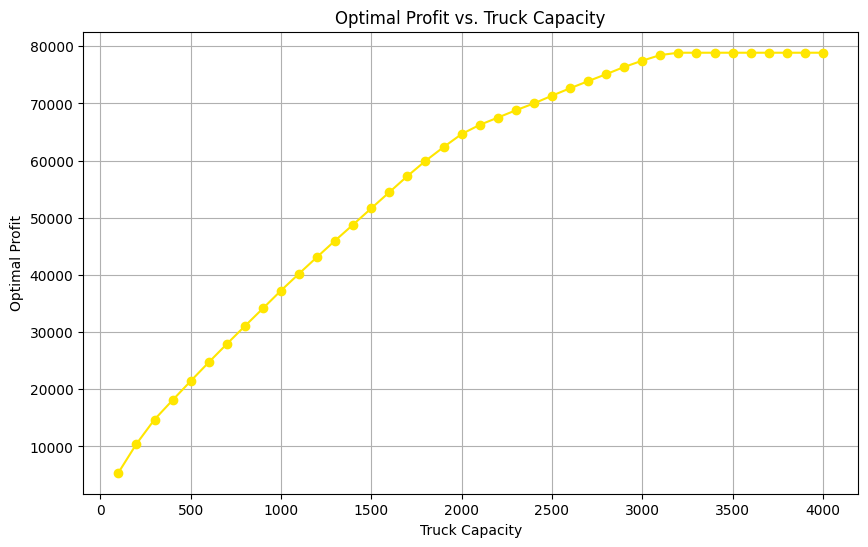

In [10]:
plot_optimal_profit(results)

In [11]:
# Interative Plot

plot_interative_optimal_profit(results)

PermissionError: Could not save file to ../../plots/. Try changing the save path.
